In [290]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [291]:
# Load the dataset to analyze and clean
file_path = 'StressLevelDataset_original.csv'
stress_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
stress_data.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20.0,0.0,11,2,1,2.0,4,2,3,...,2,3.0,2,3,3.0,2,3.0,3.0,2,1.0
1,15,8.0,1.0,15,5,3,1.0,4,3,1,...,2,1.0,4,1,5.0,1,4.0,5.0,5,2.0
2,12,18.0,1.0,14,2,1,2.0,2,2,2,...,2,2.0,3,3,2.0,2,3.0,2.0,2,1.0
3,“16”,12.0,1.0,15,4,3,1.0,3,4,2,...,2,2.0,4,1,4.0,1,4.0,4.0,5,2.0
4,16,28.0,0.0,7,2,3,5.0,1,3,2,...,3,4.0,3,1,2.0,1,5.0,0.0,5,1.0


In [292]:
# Clean numeric columns with improper formatting by removing quotes and converting to numeric
numeric_columns = [
    'anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure',
    'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety',
    'basic_needs', 'academic_performance', 'study_load','teacher_student_relationship', 'future_career_concerns',
    'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level'
]

# Convert these columns to numeric, coercing errors for invalid entries
for column in numeric_columns:
    stress_data[column] = pd.to_numeric(stress_data[column], errors='coerce', downcast='integer')

# Impute missing values:
# - Numeric columns: use the median (robust to outliers)
# - Categorical columns (if any): use the mode
for column in stress_data.columns:
    if stress_data[column].dtype == 'float64' or stress_data[column].dtype == 'int64':
        stress_data[column].fillna(stress_data[column].median(), inplace=True)
    else:
        stress_data[column].fillna(stress_data[column].mode()[0], inplace=True)



# Re-check the data for missing values after imputation
cleaned_missing_values = stress_data.isnull().sum()

# Display cleaned dataset info and remaining missing values (if any)
cleaned_missing_values


,0
anxiety_level,0
self_esteem,0
mental_health_history,0
depression,0
headache,0
blood_pressure,0
sleep_quality,0
breathing_problem,0
noise_level,0
living_conditions,0


In [293]:
# Function to identify outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.2)
    Q3 = data[column].quantile(0.8)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Check for outliers in all numeric columns
numeric_columns = stress_data.select_dtypes(include=[np.number]).columns
outlier_summary = {}

for column in numeric_columns:
    outliers = detect_outliers_iqr(stress_data, column)
    outlier_summary[column] = len(outliers)

# Display summary of outliers detected
outlier_summary



{'anxiety_level': 0,
 'self_esteem': 0,
 'mental_health_history': 0,
 'depression': 2,
 'headache': 0,
 'blood_pressure': 0,
 'sleep_quality': 0,
 'breathing_problem': 0,
 'noise_level': 4,
 'living_conditions': 12,
 'safety': 0,
 'basic_needs': 0,
 'academic_performance': 0,
 'study_load': 10,
 'teacher_student_relationship': 0,
 'future_career_concerns': 0,
 'social_support': 0,
 'peer_pressure': 0,
 'extracurricular_activities': 0,
 'bullying': 0,
 'stress_level': 0}

In [294]:
# Check the updated dataset shape after removing outliers
print(f"Dataset shape before removing outliers: {stress_data.shape}")

Dataset shape before removing outliers: (1121, 21)


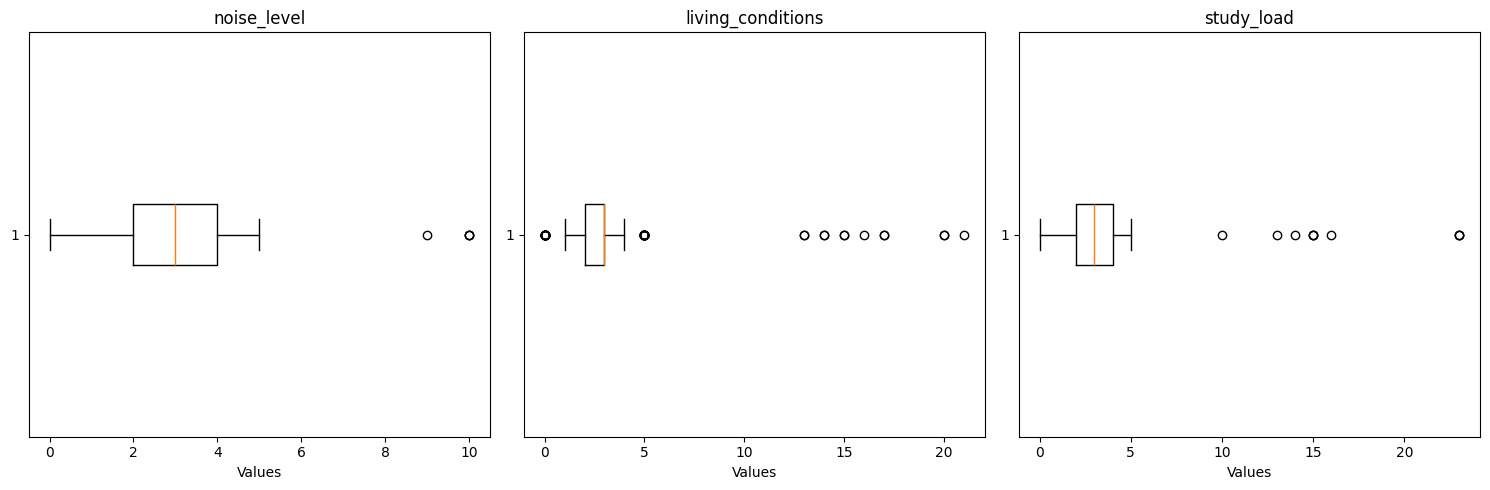

In [295]:
# Select the three columns you want to plot
columns_to_plot = ['noise_level', 'living_conditions', 'study_load']  # Replace with your column names

def plot_boxplots(data, columns):
    plt.figure(figsize=(15, 5))
    for i, column in enumerate(columns, start=1):
        plt.subplot(1, len(columns), i)
        plt.boxplot(data[column].dropna(), vert=False)
        plt.title(column)
        plt.xlabel('Values')
    plt.tight_layout()
    plt.show()

# Call the function with stress_data and the selected columns
plot_boxplots(stress_data, columns_to_plot)

In [296]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.2)
    Q3 = data[column].quantile(0.8)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Specify the columns to clean outliers
columns_with_outliers = ['noise_level', 'living_conditions', 'study_load']

# Remove outliers from each specified column
for column in columns_with_outliers:
    stress_data = remove_outliers_iqr(stress_data, column)

# Check the updated dataset shape after removing outliers
print(f"Dataset shape after removing outliers: {stress_data.shape}")

# Save the cleaned dataset to a file (optional)
stress_data.to_csv('StressLevelDataset_Cleaned.csv', index=False)


Dataset shape after removing outliers: (1101, 21)


In [297]:
# Check data types and identify potential issues
stress_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 0 to 1120
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   anxiety_level                 1101 non-null   float64
 1   self_esteem                   1101 non-null   float64
 2   mental_health_history         1101 non-null   float64
 3   depression                    1101 non-null   float64
 4   headache                      1101 non-null   int8   
 5   blood_pressure                1101 non-null   float64
 6   sleep_quality                 1101 non-null   float64
 7   breathing_problem             1101 non-null   float64
 8   noise_level                   1101 non-null   float64
 9   living_conditions             1101 non-null   float64
 10  safety                        1101 non-null   float64
 11  basic_needs                   1101 non-null   float64
 12  academic_performance          1101 non-null   float64
 13  study_lo

In [298]:
# Summary statistics to detect potential outliers or anomalies
stress_data.describe(include='all')

# Get the range of values for each column
value_ranges = stress_data.agg(['min', 'max']).transpose()

# Rename columns for clarity
value_ranges.columns = ['Min Value', 'Max Value']

# Display the result
print(value_ranges)

                              Min Value  Max Value
anxiety_level                       0.0       21.0
self_esteem                         0.0       30.0
mental_health_history               0.0        1.0
depression                          0.0      100.0
headache                            0.0        5.0
blood_pressure                      1.0        3.0
sleep_quality                       0.0        5.0
breathing_problem                   0.0        5.0
noise_level                         0.0        5.0
living_conditions                   0.0        5.0
safety                              0.0        5.0
basic_needs                         0.0        5.0
academic_performance                0.0        5.0
study_load                          0.0        5.0
teacher_student_relationship        0.0        5.0
future_career_concerns              0.0        5.0
social_support                      0.0        3.0
peer_pressure                       0.0        5.0
extracurricular_activities     

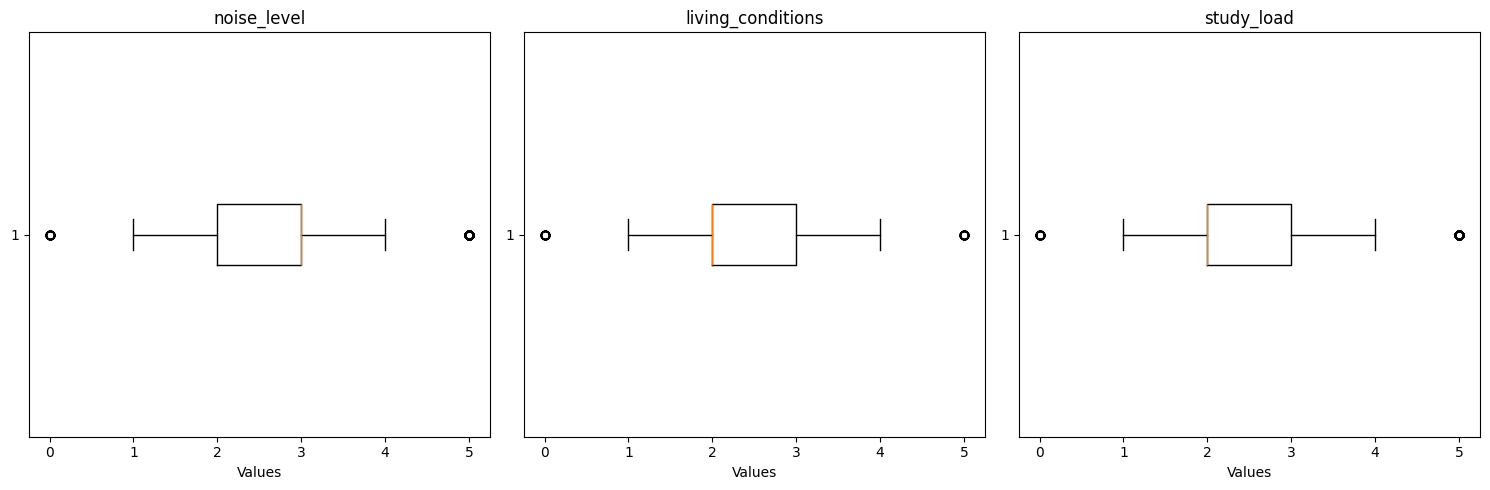

In [299]:
# Select the three columns you want to plot
columns_to_plot = ['noise_level', 'living_conditions', 'study_load']  # Replace with your column names

def plot_boxplots(data, columns):
    plt.figure(figsize=(15, 5))
    for i, column in enumerate(columns, start=1):
        plt.subplot(1, len(columns), i)
        plt.boxplot(data[column].dropna(), vert=False)
        plt.title(column)
        plt.xlabel('Values')
    plt.tight_layout()
    plt.show()

# Call the function with stress_data and the selected columns
plot_boxplots(stress_data, columns_to_plot)

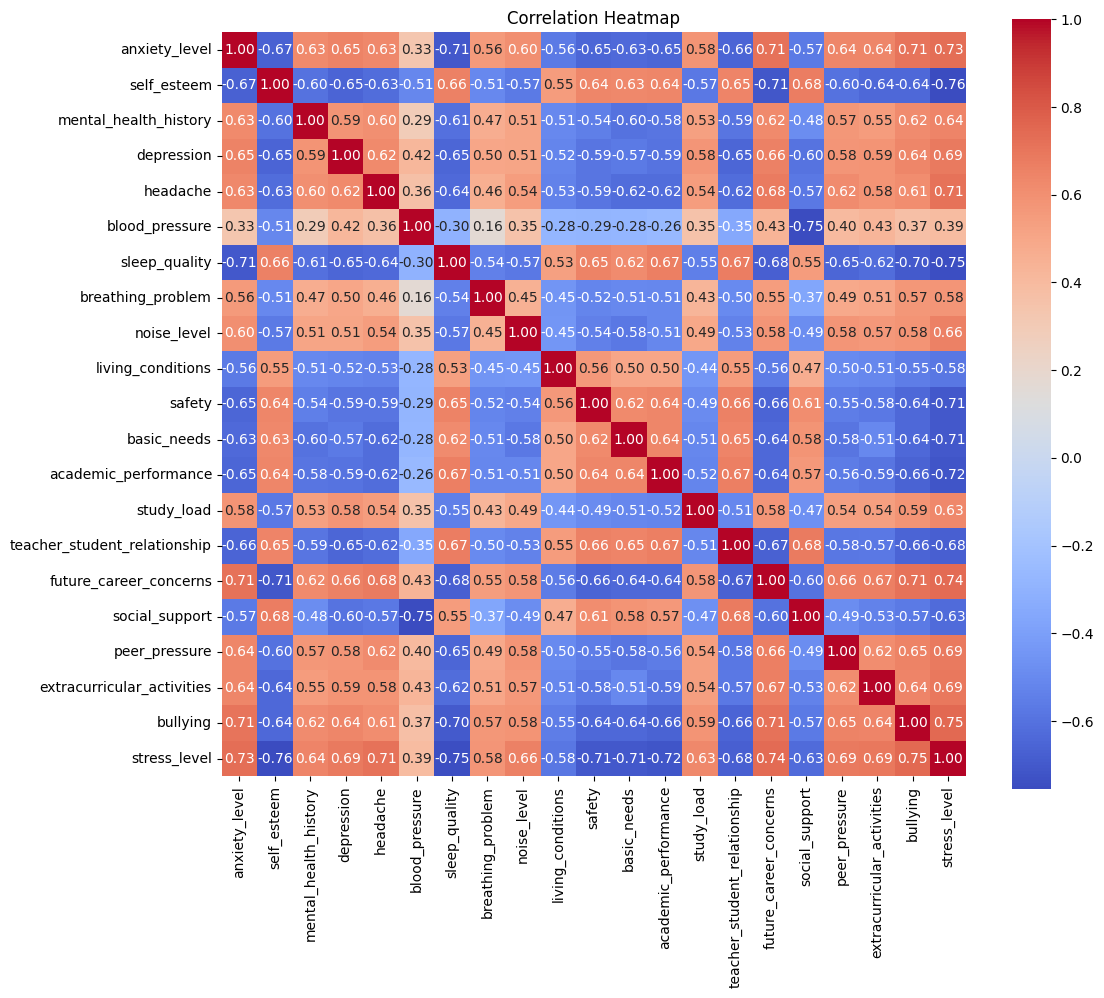

In [300]:
# Correlation matrix
corr_matrix = stress_data.corr()

# Plotting correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.show()

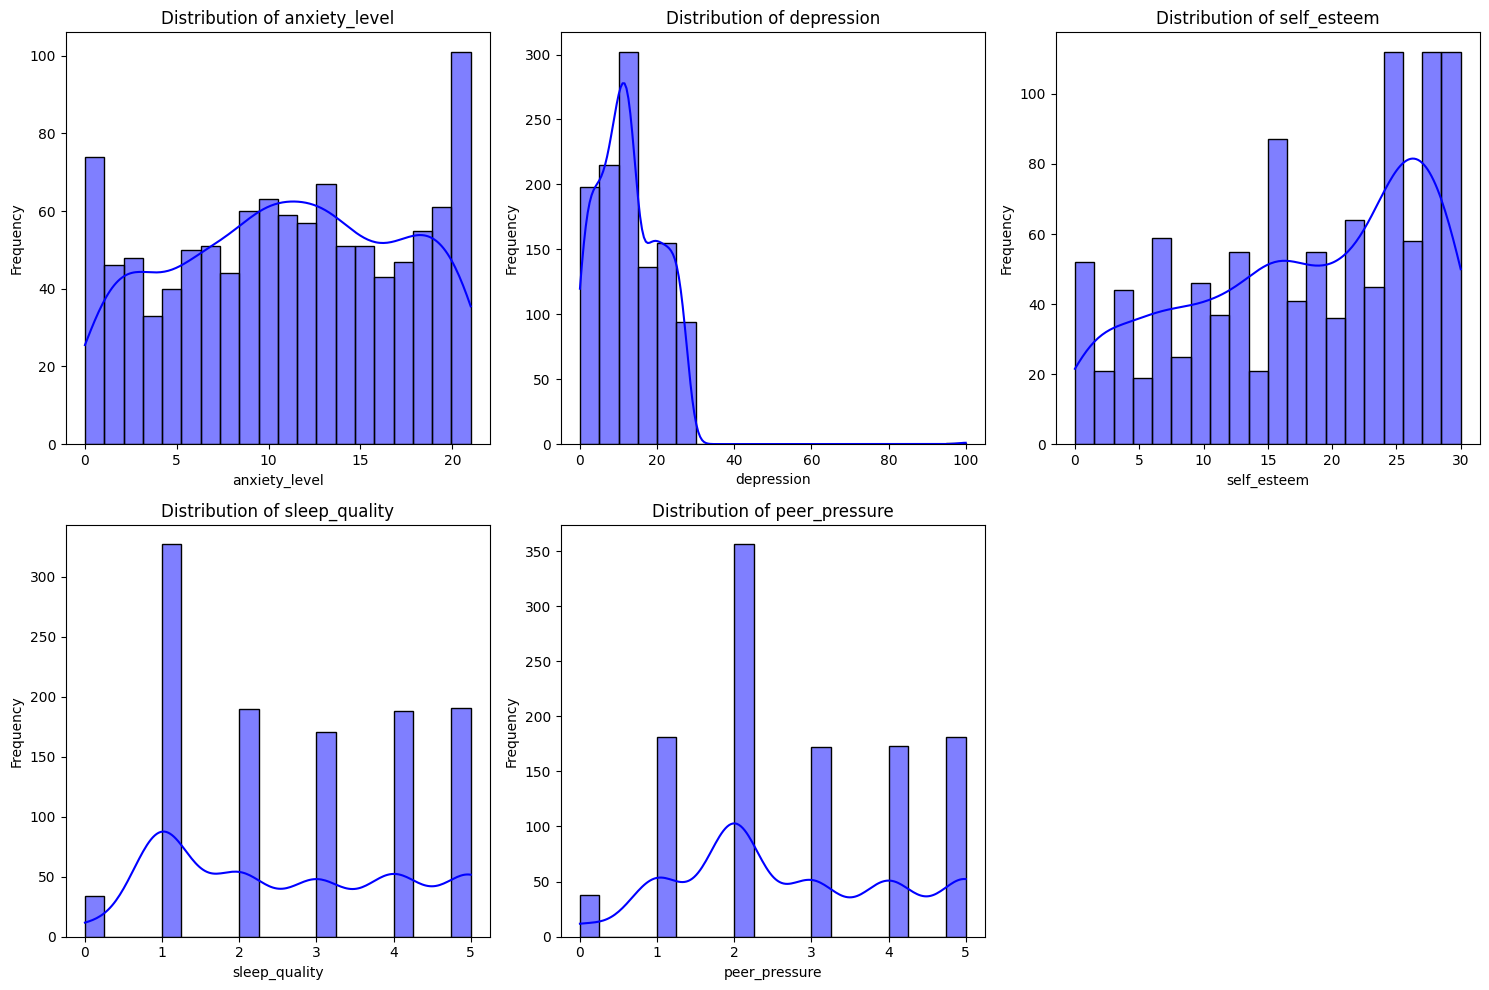

In [301]:
# Univariate analysis: Distribution plots for key features
key_features = ['anxiety_level', 'depression', 'self_esteem', 'sleep_quality', 'peer_pressure']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(stress_data[feature], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

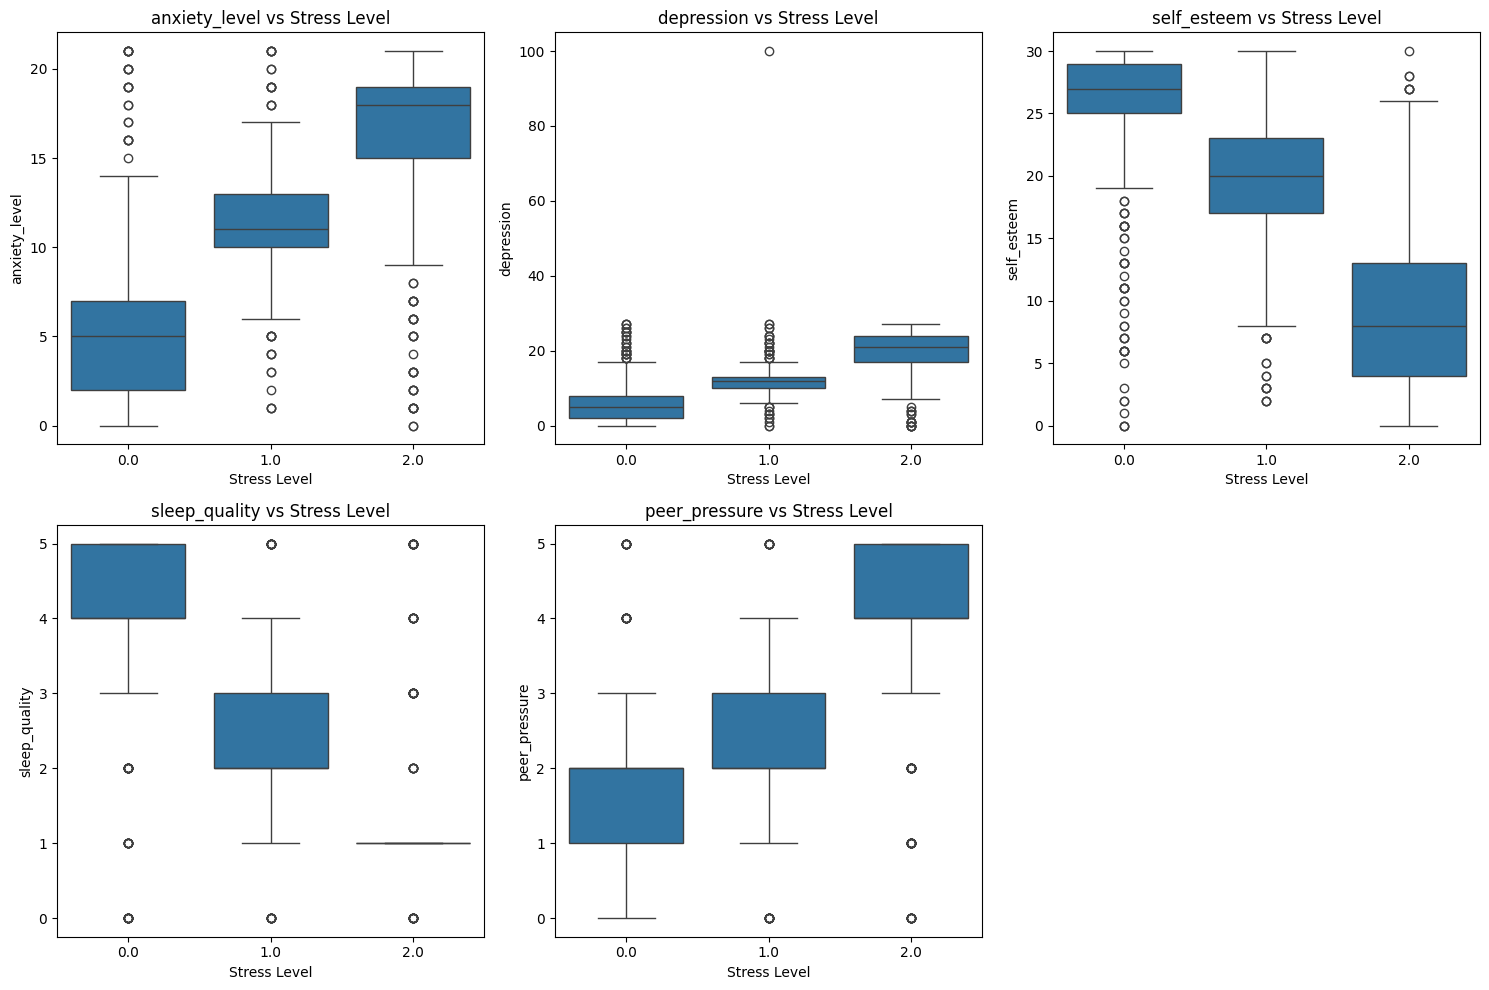

In [302]:
# Bivariate analysis: Boxplots of key features against stress_level
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=stress_data['stress_level'], y=stress_data[feature],)
    plt.title(f"{feature} vs Stress Level")
    plt.xlabel("Stress Level")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

##Descriptive Statistics
1. What is the total number of students?
2. What is thier average anxiety level?
3. What is the average sleep quality reported by students?
4. How many students experience frequent headaches?
5. What percentage of students face breathing problems?
6. How many students report high study load?

In [303]:
# Summary statistics and distribution for stress dataset

# Basic statistics
students_count = len(stress_data)
anxiety_level_avg = stress_data['anxiety_level'].mean()
students_with_mental_health_history = len(stress_data[stress_data['mental_health_history'] == 1])

# Sleep quality statistics
average_sleep_quality = stress_data['sleep_quality'].mean()
sleep_quality_levels = {
    "Low": ((stress_data['sleep_quality'] >= 0) & (stress_data['sleep_quality'] <= 2)).sum(),
    "Moderate": ((stress_data['sleep_quality'] >= 3) & (stress_data['sleep_quality'] <= 4)).sum(),
    "High": (stress_data['sleep_quality'] == 5).sum(),
}

# Headache statistics
frequent_headaches_count = (stress_data['headache'] >= 3).sum()
headache_levels = {
    "Mild": ((stress_data['headache'] >= 0) & (stress_data['headache'] <= 2)).sum(),
    "Frequent": ((stress_data['headache'] >= 3) & (stress_data['headache'] <= 4)).sum(),
    "Severe": (stress_data['headache'] == 5).sum(),
}

# Breathing problems statistics
breathing_problems_percentage = (stress_data['breathing_problem'] > 0).mean() * 100
breathing_problems_severe_percentage = (stress_data['breathing_problem'] > 4).mean() * 100
breathing_problem_levels = {
    "Rare": ((stress_data['breathing_problem'] >= 1) & (stress_data['breathing_problem'] <= 2)).sum(),
    "Frequent": ((stress_data['breathing_problem'] >= 3) & (stress_data['breathing_problem'] <= 4)).sum(),
    "Chronic": (stress_data['breathing_problem'] == 5).sum(),
}

# Study load statistics
high_study_load_count = (stress_data['study_load'] >= 4).sum()
study_load_levels = {
    "Low": ((stress_data['study_load'] >= 0) & (stress_data['study_load'] <= 2)).sum(),
    "Moderate": (stress_data['study_load'] == 3).sum(),
    "High": ((stress_data['study_load'] >= 4) & (stress_data['study_load'] <= 5)).sum(),
}

# Display results
print(f"Total Students: {students_count}")
print(f"Average Anxiety Level: {anxiety_level_avg:.2f}")
print(f"Students with Mental Health History: {students_with_mental_health_history}\n")

print(f"Average Sleep Quality: {average_sleep_quality:.2f}")
print("Sleep Quality Levels:", sleep_quality_levels, "\n")

print(f"Frequent Headaches Count: {frequent_headaches_count}")
print("Headache Levels:", headache_levels, "\n")

print(f"Percentage with Breathing Problems: {breathing_problems_percentage:.2f}%")
print(f"Severe Breathing Problems: {breathing_problems_severe_percentage:.2f}%")
print("Breathing Problem Levels:", breathing_problem_levels, "\n")

print("Study Load Levels:", study_load_levels)
print(f"High Study Load Count: {high_study_load_count}")


Total Students: 1101
Average Anxiety Level: 11.07
Students with Mental Health History: 542

Average Sleep Quality: 2.66
Sleep Quality Levels: {'Low': 551, 'Moderate': 359, 'High': 191} 

Frequent Headaches Count: 557
Headache Levels: {'Mild': 544, 'Frequent': 428, 'Severe': 129} 

Percentage with Breathing Problems: 96.19%
Severe Breathing Problems: 11.53%
Breathing Problem Levels: {'Rare': 502, 'Frequent': 430, 'Chronic': 127} 

Study Load Levels: {'Low': 555, 'Moderate': 275, 'High': 271}
High Study Load Count: 271


##Psychological Factors Analysis

###This analysis examines key psychological factors among students. The columns considered include:

- Anxiety Level: Measures the level of anxiety on a numeric scale.
- Mental Health History: Indicates if a student has a history of mental health issues (binary: 1 for yes, 0 for no).
- Self-Esteem: Measures self-esteem levels.
Depression: Captures the level of depressive symptoms.
- Stress Level: Assesses the stress level on a numeric scale.

###Key Questions
- What is the average anxiety level among students?
- How many students report a history of mental health issues?
- What is the average self-esteem level?
What is the distribution of stress levels across depression levels?

In [304]:
# Define bins and labels for anxiety level and stress level
anxiety_bins = [0, 2, 4, 6, 8, 10]  # Adjust based on dataset range
anxiety_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

stress_bins = [0, 1, 2, 3]  # Adjust based on dataset range
stress_labels = ['Low Stress', 'Moderate Stress', 'High Stress']

# Define bins and labels for depression levels
depression_bins = [0, 2, 4, 6, 8, 10]
depression_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Bin the anxiety levels, stress levels, and depression levels
stress_data_temp_temp = stress_data.copy()
stress_data_temp['anxiety_range'] = pd.cut(stress_data_temp['anxiety_level'], bins=anxiety_bins, labels=anxiety_labels, right=False)
stress_data_temp['stress_range'] = pd.cut(stress_data_temp['stress_level'], bins=stress_bins, labels=stress_labels, right=False)
stress_data_temp['depression_range'] = pd.cut(stress_data_temp['depression'], bins=depression_bins, labels=depression_labels, right=False)

# Group by depression range and stress range to find the distribution
stress_depression_distribution = stress_data_temp.groupby('depression_range')['stress_range'].value_counts()

# Calculate key statistics
psychological_stats = {
    "Average Anxiety Level": stress_data_temp['anxiety_level'].mean(),
    "Students with Mental Health Issues": stress_data_temp['mental_health_history'].sum(),
    "Average Self-Esteem Level": stress_data_temp['self_esteem'].mean(),
    "Stress Level Distribution by Depression Level": stress_depression_distribution
}

# Display results
for key, value in psychological_stats.items():
    print(f"{key}:")
    print(value)
    print()


Average Anxiety Level:
11.074477747502272

Students with Mental Health Issues:
542.0

Average Self-Esteem Level:
17.780199818346958

Stress Level Distribution by Depression Level:
depression_range  stress_range   
Very Low          Low Stress         65
                  High Stress        12
                  Moderate Stress     3
Low               Low Stress         76
                  Moderate Stress     5
                  High Stress         2
Moderate          Low Stress         70
                  Moderate Stress     4
                  High Stress         4
High              Low Stress         66
                  Moderate Stress     9
                  High Stress         3
Very High         Low Stress         51
                  Moderate Stress    40
                  High Stress         3
Name: count, dtype: int64



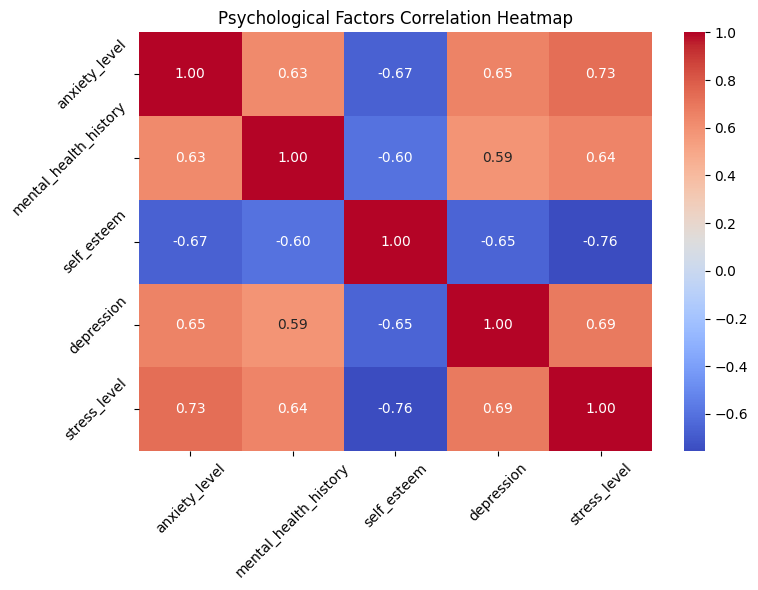

In [305]:
# Psychological Factors
psychological_columns = ['anxiety_level', 'mental_health_history', 'self_esteem', 'depression', 'stress_level']

# Compute correlation matrix for psychological factors
psychological_corr = stress_data[psychological_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(psychological_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Psychological Factors Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


##Physiological Factors Analysis
###This analysis examines physiological factors impacting students' well-being
The columns considered include:

- Headache: Frequency and severity of headaches (e.g., higher scores indicate more frequent/severe headaches)
- Blood Pressure: Numeric measure of blood pressure.

- Sleep Quality: Numeric score representing the quality of sleep.

- Breathing Problem: Numeric score representing the severity of breathing problems.

###Key Questions
- What is the average sleep quality?
- How many students experience frequent headaches (e.g., headache score ≥ 3)?- What percentage of students face chronic breathing problems (e.g., breathing problem score = 5)?
- What is the average blood pressure?
- How are blood pressure and stress levels correlated?

In [306]:
# Calculate physiological statistics
physiological_stats = {
    "Average Sleep Quality": stress_data['sleep_quality'].mean(),
    "Students with Frequent Headaches": (stress_data['headache'] >= 3).sum(),
    "Percentage with Chronic Breathing Problems": (stress_data['breathing_problem'] == 5).mean() * 100,
    "Average Blood Pressure": stress_data['blood_pressure'].mean(),
    "Correlation of Blood Pressure with Stress": stress_data['blood_pressure'].corr(stress_data['stress_level']),
}

# Display results
for key, value in physiological_stats.items():
    print(f"{key}:")
    print(value)
    print()

Average Sleep Quality:
2.6584922797456856

Students with Frequent Headaches:
557

Percentage with Chronic Breathing Problems:
11.53496821071753

Average Blood Pressure:
2.1834695731153495

Correlation of Blood Pressure with Stress:
0.3927527170803515



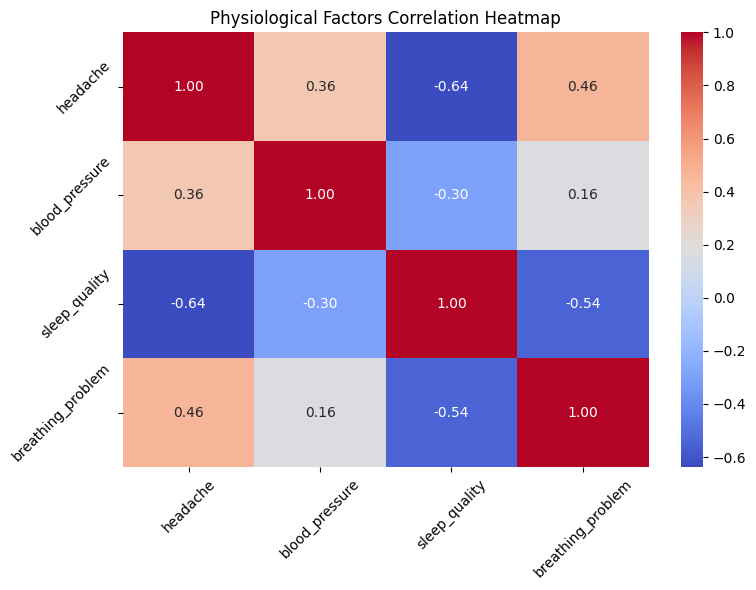

In [307]:
# Physiological Factors
physiological_columns = ['headache', 'blood_pressure', 'sleep_quality', 'breathing_problem']

# Compute correlation matrix for physiological factors
physiological_corr = stress_data[physiological_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(physiological_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Physiological Factors Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

##Environmental Factors Analysis
###This analysis focuses on environmental factors that influence students' well-being
- The selected columns are:
- Noise Level: Numeric score representing the intensity of noise in a student's environment.
- Living Conditions: Numeric score indicating the quality of living conditions.
- Safety: Numeric score reflecting the perception of safety in the environment.
- Basic Needs: Numeric score measuring the availability of essential resources like food, water, and shelter.
###Key Questions
- What is the average score for living conditions?
- How does noise level correlate with stress levels?
- What percentage of students report feeling unsafe (e.g., safety score ≤ 2)?
- What percentage of students experience low availability of basic resources (e.g., basic needs score ≤ 2)?

In [308]:
# Calculate environmental statistics
environmental_stats = {
    "Average Living Conditions": stress_data['living_conditions'].mean(),
    "Correlation of Noise Level with Stress": stress_data['noise_level'].corr(stress_data['stress_level']),
    "Percentage of Students Feeling Unsafe": (stress_data['safety'] <= 2).mean() * 100,
    "Percentage of Students with Low Resource Availability": (stress_data['basic_needs'] <= 2).mean() * 100,
}

# Display results
for key, value in environmental_stats.items():
    print(f"{key}:")
    print(value)
    print()


Average Living Conditions:
2.516802906448683

Correlation of Noise Level with Stress:
0.6620000631734798

Percentage of Students Feeling Unsafe:
51.49863760217984

Percentage of Students with Low Resource Availability:
49.863760217983646



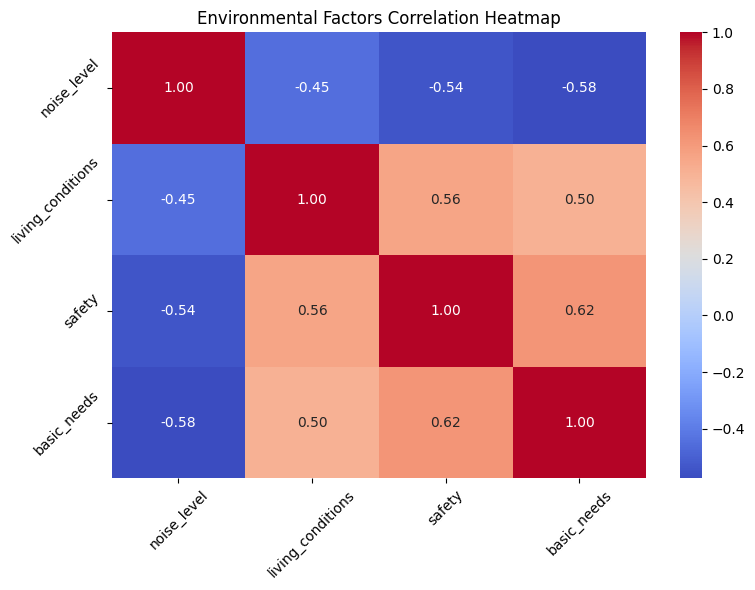

In [309]:
# Environmental Factors
environmental_columns = ['noise_level', 'living_conditions', 'safety', 'basic_needs']

# Compute correlation matrix for environmental factors
environmental_corr = stress_data[environmental_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(environmental_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Environmental Factors Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


##Academic Factors Analysis
###This analysis focuses on the academic pressures and their impact on students' stress levels. The selected columns are:
- Academic Performance: Numeric score representing students' academic achievements.
- Study Load: Numeric score indicating the intensity of academic workload.
-
 Teacher-Student Relationship:
Numeric score reflecting the quality of interaction and relationship between students and their teachers.
- Future Career Concerns: Numeric score indicating the level of stress or anxiety related to career prospects.
###Key Questions
- How many students report a high study load (e.g., score ≥ 4)?
- What is the correlation between academic performance and stress levels?
- What is the average teacher-student relationship score, and how does it correlate with stress?
- What is the average score for future career concerns, and how does it relate to stress?

In [310]:
# Calculate academic statistics
academic_stats = {
    "Students with High Study Load": (stress_data['study_load'] >= 4).sum(),
    "Correlation of Academic Performance with Stress": stress_data['academic_performance'].corr(stress_data['stress_level']),
    "Average Teacher-Student Relationship Score": stress_data['teacher_student_relationship'].mean(),
    "Correlation of Teacher-Student Relationship with Stress": stress_data['teacher_student_relationship'].corr(stress_data['stress_level']),
    "Average Score for Future Career Concerns": stress_data['future_career_concerns'].mean(),
    "Correlation of Future Career Concerns with Stress": stress_data['future_career_concerns'].corr(stress_data['stress_level']),
}

# Display results
for key, value in academic_stats.items():
    print(f"{key}:")
    print(value)
    print()


Students with High Study Load:
271

Correlation of Academic Performance with Stress:
-0.7183724309785502

Average Teacher-Student Relationship Score:
2.6439600363306086

Correlation of Teacher-Student Relationship with Stress:
-0.6762927690302191

Average Score for Future Career Concerns:
2.647593097184378

Correlation of Future Career Concerns with Stress:
0.7396744752824397



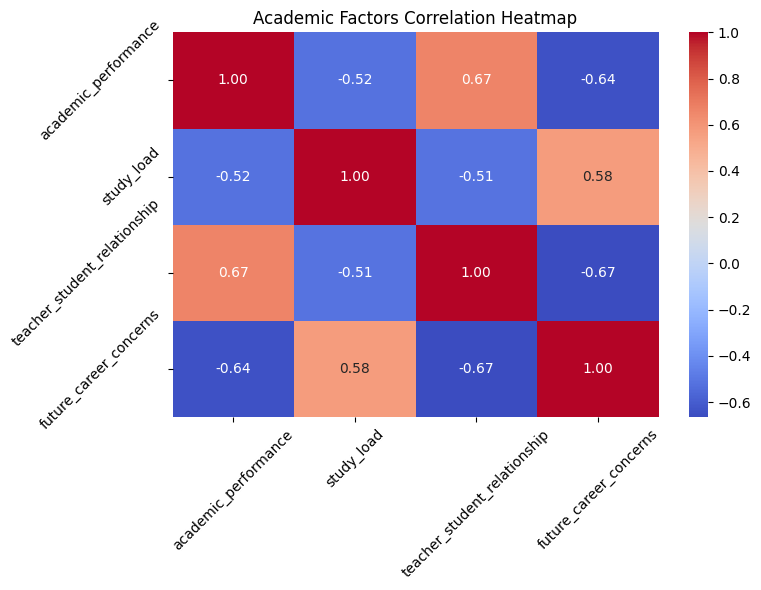

In [311]:
# Academic Factors
academic_columns = ['academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns']

# Compute correlation matrix for academic factors
academic_corr = stress_data[academic_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(academic_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Academic Factors Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

##Social Factors Analysis
###This analysis explores the role of social dynamics in influencing students' stress levels. The selected columns are:

- Social Support: A numeric score indicating the level of emotional and practical support received from peers, family, or others.
- Peer Pressure: A numeric score reflecting the degree of influence peers exert on decision-making or behaviors.
- Extracurricular Activities: A numeric score indicating participation and engagement in non-academic activities.
- Bullying: A numeric score representing exposure to bullying incidents.
###Key Questions
- What is the average score for social support?
- How many students report experiencing high peer pressure (e.g., score ≥ 4)?
- What percentage of students are actively involved in extracurricular activities (e.g., score ≥ 3)?
- How does bullying correlate with stress levels?

In [312]:
# Calculate social statistics
social_stats = {
    "Average Social Support Score": stress_data['social_support'].mean(),
    "Students Experiencing High Peer Pressure": (stress_data['peer_pressure'] >= 4).sum(),
    "Percentage of Students Active in Extracurricular Activities": (stress_data['extracurricular_activities'] >= 3).mean() * 100,
    "Correlation of Social Support with Stress": stress_data['social_support'].corr(stress_data['stress_level']),
    "Correlation of Peer Pressure with Stress": stress_data['peer_pressure'].corr(stress_data['stress_level']),
    "Correlation of Extracurricular Activities with Stress": stress_data['extracurricular_activities'].corr(stress_data['stress_level']),
    "Correlation of Bullying with Stress": stress_data['bullying'].corr(stress_data['stress_level']),
}

# Display results
for key, value in social_stats.items():
    print(f"{key}:")
    print(value)
    print()


Average Social Support Score:
1.8819255222524978

Students Experiencing High Peer Pressure:
354

Percentage of Students Active in Extracurricular Activities:
50.04541326067211

Correlation of Social Support with Stress:
-0.6309654593937087

Correlation of Peer Pressure with Stress:
0.6870964221335266

Correlation of Extracurricular Activities with Stress:
0.69196767429611

Correlation of Bullying with Stress:
0.749511909895455



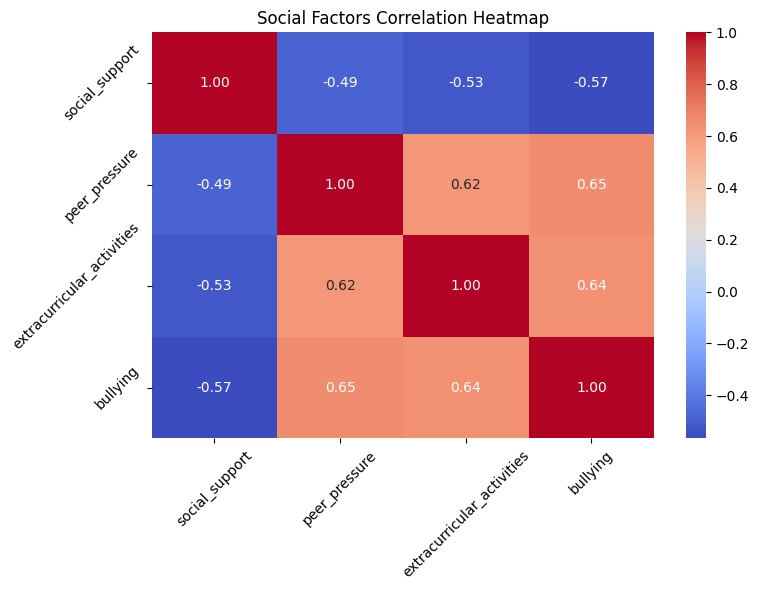

In [313]:
# Social Factors
social_columns = ['social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']

# Compute correlation matrix for social factors
social_corr = stress_data[social_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(social_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Social Factors Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [314]:
stress_data.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14.0,20.0,0.0,11.0,2,1.0,2.0,4.0,2.0,3.0,...,2.0,3.0,2,3.0,3.0,2.0,3.0,3.0,2.0,1.0
1,15.0,8.0,1.0,15.0,5,3.0,1.0,4.0,3.0,1.0,...,2.0,1.0,4,1.0,5.0,1.0,4.0,5.0,5.0,2.0
2,12.0,18.0,1.0,14.0,2,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3,3.0,2.0,2.0,3.0,2.0,2.0,1.0
3,11.0,12.0,1.0,15.0,4,3.0,1.0,3.0,4.0,2.0,...,2.0,2.0,4,1.0,4.0,1.0,4.0,4.0,5.0,2.0
4,16.0,28.0,0.0,7.0,2,3.0,5.0,1.0,3.0,2.0,...,3.0,4.0,3,1.0,2.0,1.0,5.0,0.0,5.0,1.0


## Machine Learning Analysis
### Models Tested
The following regression models were evaluated:
Baseline model, Linear Regression, Ridge and Lasso Regression, Random Forest, Gradient Boosting, Decision Tree, Support Vector Regressor, K-Nearest Neighbors


###Baseline Model

In [315]:
class MajorityLabelClassifier():
    """
    A classifier that predicts the mode of training labels.
    """
    def __init__(self):
        """
        Initialize your parameter here.
        """
        self.majority_label = None

    def fit(self, X, y):
        """
        Implement fit by taking training data X and their labels y and finding the mode of y
        i.e. store your learned parameter.
        """
        mode_result = scipy.stats.mode(y)
        # If mode is an array (more than one mode), take the first one
        self.majority_label = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode
        return self

    def predict(self, X):
        """
        Implement to give the mode of training labels as a prediction for each data instance in X.
        Return labels.
        """
        return np.full(X.shape[0], self.majority_label)


# Assuming `df` is the dataframe with your data
# Example of how to use this with your dataset:

# Convert features and labels
# Assuming 'stress_level' is the target variable y
# Remove the target column and convert it to the appropriate labels

X = stress_data.drop(columns=['stress_level'])  # Features (excluding the target column)
y = stress_data['stress_level']  # Labels (the target column)

# Convert to numpy arrays
X = X.to_numpy()
y = y.to_numpy()

# Initialize the MajorityLabelClassifier
baselineClf = MajorityLabelClassifier()

# Fit the classifier
baselineClf.fit(X, y)

# Make predictions
predictions = baselineClf.predict(X)

# Calculate training accuracy
training_accuracy = np.mean(predictions == y)

# Print the training accuracy
print(f"Training accuracy of baseline model: {training_accuracy:.4f}")

Training accuracy of baseline model: 0.3388


###Logistic Regression

In [316]:
# Create a copy of the DataFrame
df_processed = stress_data.copy()

# Psychological Factors Analysis
# Define bins and labels for anxiety_level and stress_level
anxiety_bins = [0, 2, 4, 6, 8, 10]  # Example: Adjust based on the dataset range
anxiety_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

stress_bins = [0, 1, 2, 3]  # Example: Adjust based on the dataset range
stress_labels = ['Low Stress', 'Moderate Stress', 'High Stress']

# Bin the anxiety levels and stress levels
df_processed['anxiety_range'] = pd.cut(df_processed['anxiety_level'], bins=anxiety_bins, labels=anxiety_labels, right=False)
df_processed['stress_range'] = pd.cut(df_processed['stress_level'], bins=stress_bins, labels=stress_labels, right=False)

# Group by anxiety range and stress range to find the distribution
stress_anxiety_distribution = df_processed.groupby('anxiety_range')['stress_range'].value_counts()

psychological_stats = {
    "Average Anxiety Level": df_processed['anxiety_level'].mean(),
    "Students with Mental Health Issues": df_processed['mental_health_history'].sum(),
    "Percentage with Emotional Support": (df_processed['social_support'] > 0).mean() * 100,
    "Stress Level Distribution by Anxiety Level": df_processed.groupby('anxiety_range')['stress_range'].value_counts()
}


# Display the distribution
# print("Stress Level Distribution by Anxiety Level (Grouped into Ranges):")
# print(stress_anxiety_distribution)
for key, value in psychological_stats.items():
    print(f"{key}:")
    print(value)
    print()

# Split features and target variable
X = df_processed.drop(['stress_level', 'anxiety_range', 'stress_range'], axis=1)  # Drop categorical columns from the copy
y = df_processed['stress_level']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initial Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

logistic_regression_accuracy = accuracy_score(y_test, y_pred)

# Initial Evaluation
print("Initial Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", logistic_regression_accuracy)

# Increase max_iter to resolve convergence issues
log_reg = LogisticRegression(max_iter=5000, random_state=42)

# Refined GridSearchCV parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nFinal Evaluation after Hyperparameter Tuning:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Average Anxiety Level:
11.074477747502272

Students with Mental Health Issues:
542.0

Percentage with Emotional Support:
91.9164396003633

Stress Level Distribution by Anxiety Level:
anxiety_range  stress_range   
Very Low       Low Stress         63
               High Stress         8
               Moderate Stress     3
Low            Low Stress         82
               High Stress         9
               Moderate Stress     3
Moderate       Low Stress         60
               Moderate Stress     8
               High Stress         5
High           Low Stress         86
               High Stress        10
               Moderate Stress     5
Very High      Moderate Stress    54
               Low Stress         45
               High Stress         5
Name: count, dtype: int64

Initial Evaluation:
Confusion Matrix:
[[63  6  6]
 [ 3 66  3]
 [ 7  1 66]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       

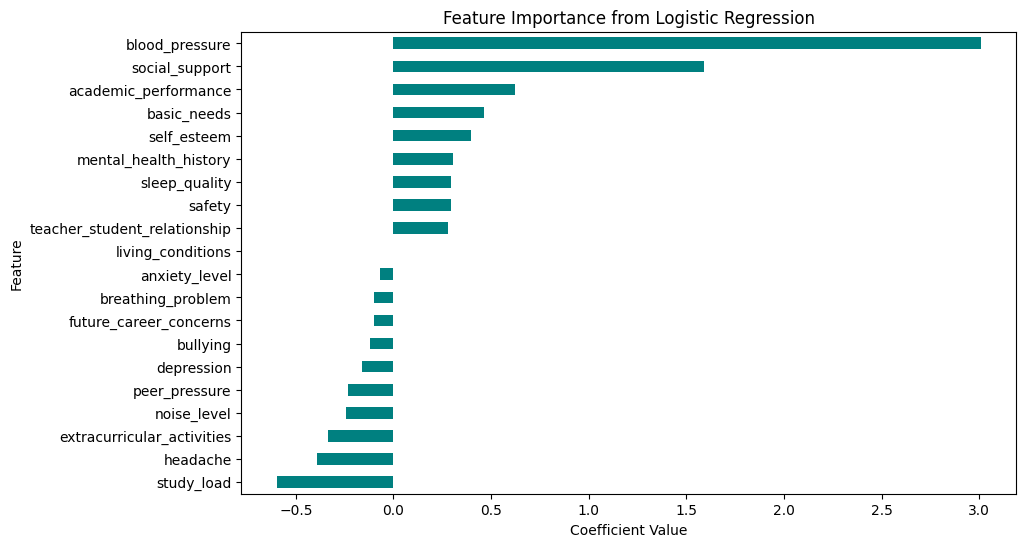

In [317]:
# Extract feature importance
feature_importance = pd.Series(best_model.coef_[0], index=X.columns).sort_values()

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', color='teal')
plt.title("Feature Importance from Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


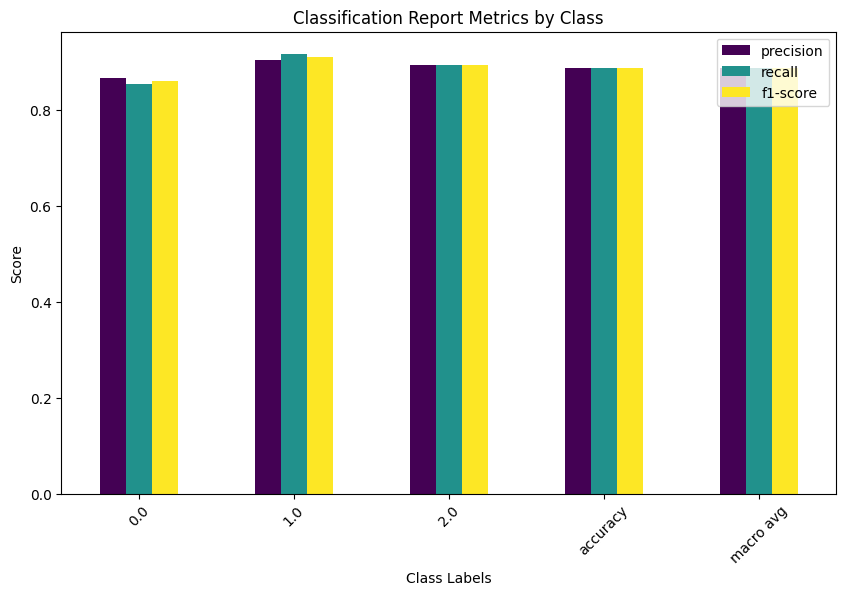

In [318]:
report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Bar plot of precision, recall, and f1-score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Classification Report Metrics by Class")
plt.xlabel("Class Labels")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

###Random Forest


In [319]:
# Create a copy of the original dataframe
df_processed = stress_data.copy()

# Convert features and labels
X = df_processed.drop(columns=['stress_level'])  # Features (excluding the target column)
y = df_processed['stress_level']  # Labels (the target column)

# ----> Identify and convert non-numerical columns to numerical representations
# For example, if 'column_name' is the column containing categorical data:
# X['column_name'] = X['column_name'].map({'Moderate': 1, 'Low': 0, 'High': 2})
# You'll need to adjust the mapping based on the actual values in your column.

# Select only numerical features for scaling
numerical_features = X.select_dtypes(include=['number']).columns
X_numerical = X[numerical_features]

# Convert to numpy arrays
X_numerical = X_numerical.to_numpy()  # ----> Scales only numerical features
y = y.to_numpy()

# Optional: Standardize the features for better performance of the model (not always necessary for RandomForest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)  # ----> Scales only numerical features

# Split the dataset into training and testing sets (80% train, 20% test)
# ----> Use the scaled numerical features and original DataFrame for splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_clf.predict(X_test)

# Calculate the accuracy on the test data
rf_accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Test accuracy of Random Forest Classifier: {rf_accuracy:.4f}")

# Optionally: Print feature importance if needed
feature_importances = rf_clf.feature_importances_
print("Feature Importances:", feature_importances)


Test accuracy of Random Forest Classifier: 0.8552
Feature Importances: [0.06708287 0.06432104 0.00483518 0.04800619 0.02316457 0.20035225
 0.08904504 0.01413463 0.02566961 0.01332716 0.03715168 0.06640457
 0.02172073 0.01201049 0.06857851 0.06344498 0.03848737 0.02541776
 0.06318585 0.05365951]


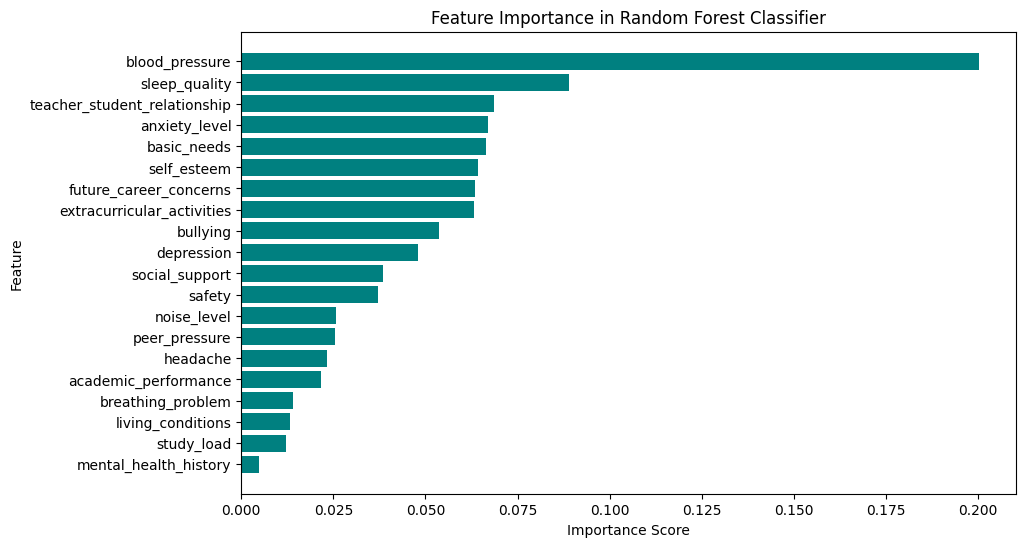

In [320]:
feature_importances_df = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='teal')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.title("Feature Importance in Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


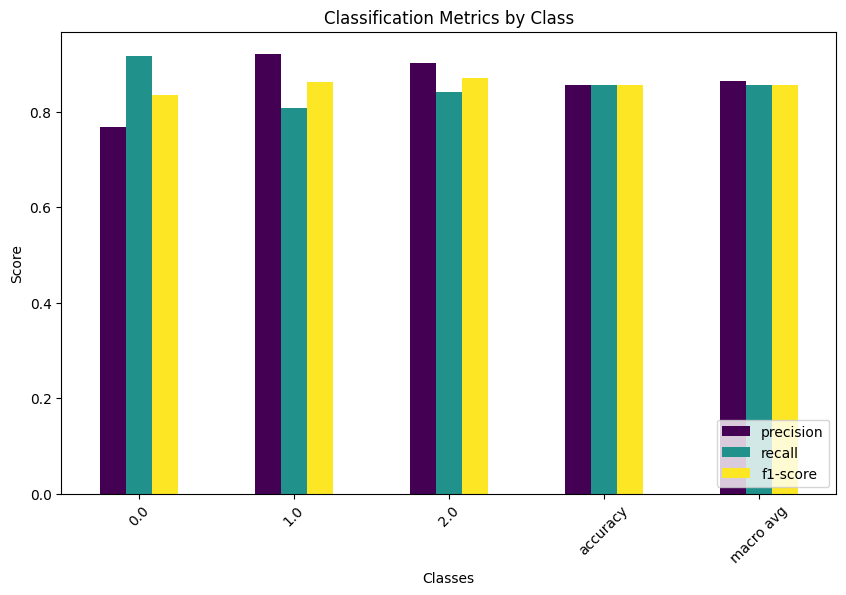

In [321]:
# Generate classification report as a DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score
report_df.iloc[:-1, :-1].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Classification Metrics by Class")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


XGBoost

In [322]:
# Create a copy of the original DataFrame
df_processed = stress_data.copy()

# Convert features and labels
X = df_processed.drop(columns=['stress_level'])  # Features (excluding the target column)
y = df_processed['stress_level']  # Labels (the target column)

# ----> Identify and convert non-numerical columns to numerical representations (if necessary)
# Example mapping for categorical columns:
# X['column_name'] = X['column_name'].map({'Moderate': 1, 'Low': 0, 'High': 2})

# Select only numerical features for scaling
numerical_features = X.select_dtypes(include=['number']).columns
X_numerical = X[numerical_features]

# Convert to numpy arrays
X_numerical = X_numerical.to_numpy()
y = y.to_numpy()

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(
    n_estimators=100,         # Number of boosting rounds (trees)
    learning_rate=0.1,        # Step size shrinkage
    max_depth=3,              # Maximum tree depth
    random_state=42,
    use_label_encoder=False,  # Avoids deprecation warning in newer XGBoost versions
    eval_metric='logloss'     # Evaluation metric for classification tasks
)

# Train the XGBoost model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy on the test data
XGB_accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Test Accuracy of XGBoost Classifier: {XGB_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy of XGBoost Classifier: 0.8643

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.87        72
         1.0       0.88      0.84      0.86        73
         2.0       0.88      0.86      0.87        76

    accuracy                           0.86       221
   macro avg       0.87      0.86      0.86       221
weighted avg       0.87      0.86      0.86       221


Confusion Matrix:
[[65  3  4]
 [ 7 61  5]
 [ 6  5 65]]


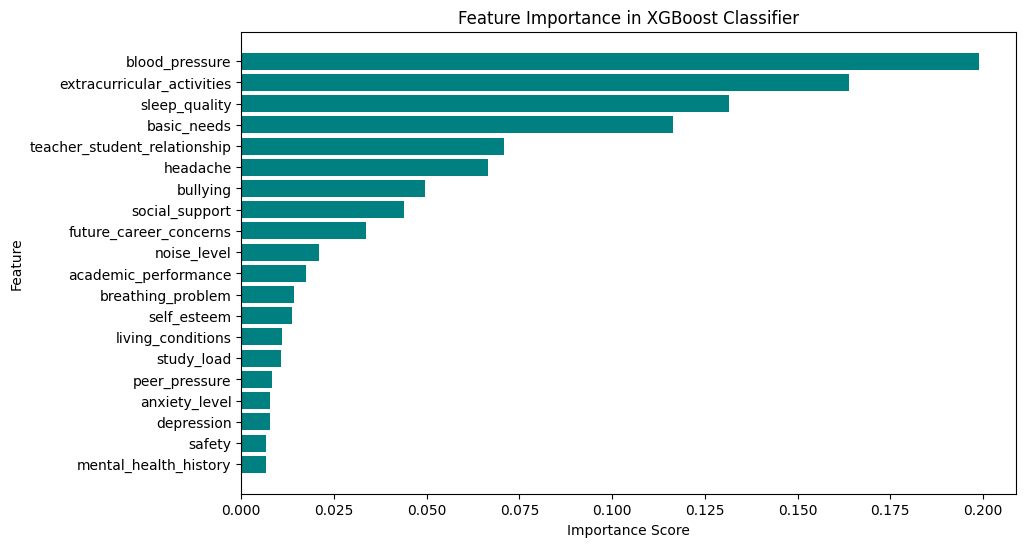

In [323]:
# Create a DataFrame for feature importance
feature_importances_df = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='teal')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title("Feature Importance in XGBoost Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

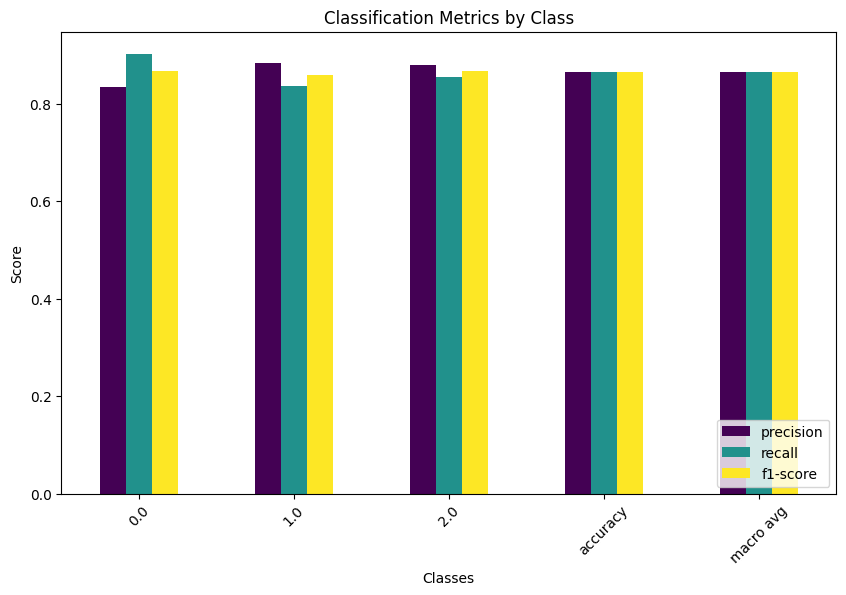

In [324]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score
report_df.iloc[:-1, :-1].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Classification Metrics by Class")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()


###Support Vector Machine

In [325]:
#Now, let's apply this.
sdf_m = stress_data.copy()
def apply_0_mapping(df,x,map_arr):
    for index, row in stress_data.iterrows():
        if row[x]==0:
          stress_level = int(row['stress_level'])  # Ensure stress_level is an integer
          df.at[index, x] = map_arr[stress_level]

apply_0_mapping(sdf_m, 'headache',[0,2,4])
apply_0_mapping(sdf_m, 'sleep_quality',[0,3,4])
apply_0_mapping(sdf_m, 'breathing_problem',[0,2,5])
apply_0_mapping(sdf_m, 'noise_level',[0,3,5])
apply_0_mapping(sdf_m, 'living_conditions',[4,5,0])
apply_0_mapping(sdf_m, 'safety',[5,3,0])
apply_0_mapping(sdf_m, 'basic_needs',[5,3,0])
apply_0_mapping(sdf_m, 'academic_performance',[5,3,0])
apply_0_mapping(sdf_m, 'study_load',[0,3,5])
apply_0_mapping(sdf_m, 'teacher_student_relationship',[5,3,0])
apply_0_mapping(sdf_m, 'future_career_concerns',[0,3,5])
apply_0_mapping(sdf_m, 'social_support',[3,2,0])
apply_0_mapping(sdf_m, 'peer_pressure',[0,3,5])
apply_0_mapping(sdf_m, 'extracurricular_activities',[0,3,5])
apply_0_mapping(sdf_m, 'bullying',[0,3,5])

In [326]:
sdf_msvc=sdf_m.copy()
def square_living_conditions(lc):
    return (3.3-lc)*(3.3-lc)
sdf_msvc['living_conditions_squared']=sdf_msvc['living_conditions'].apply(square_living_conditions)
def std_col(df,column_to_standardize, scaler):
    df[column_to_standardize] = scaler.fit_transform(df[[column_to_standardize]])
def std_df(df, scaler):
    cols = ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']
    for c in cols:
        std_col(df,c, scaler)
def std_df_svc(df, scaler):
    cols = ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'living_conditions_squared', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']
    for c in cols:
        std_col(df,c, scaler)

In [327]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
num_folds = 5
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=100)
X = sdf_msvc.drop('stress_level', axis=1)
Y = sdf_msvc['stress_level']
X_train = [None] * num_folds
X_test = [None] * num_folds
Y_test = [None] * num_folds
Y_train = [None] * num_folds
scalers = [None] * num_folds
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, Y)):
    X_train[fold], X_test[fold] = X.iloc[train_index], X.iloc[test_index]
    Y_train[fold], Y_test[fold] = Y.iloc[train_index], Y.iloc[test_index]
    scalers[fold] = StandardScaler()
    X_train[fold] = scalers[fold].fit_transform(X_train[fold])
    X_test[fold] = scalers[fold].transform(X_test[fold])
    #print(Y_test[fold])

Average accuracy for C = 0.01: 0.9255491567256273
Average accuracy for C = 0.1: 0.9337104072398189
Average accuracy for C = 1: 0.9328054298642534
Average accuracy for C = 10: 0.9273549979432332
Average accuracy for C = 100: 0.9264459070341422


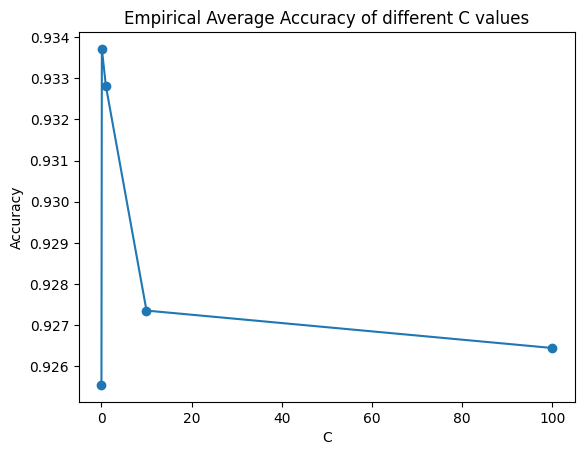

In [328]:
from sklearn import metrics

def test_c(c):
    total_accuracy = 0
    for fold in range(num_folds):
        model = SVC(kernel='linear', C=c, decision_function_shape='ovr',)
        model.fit(X_train[fold], Y_train[fold])
        y_pred = model.predict(X_test[fold])
        accuracy = metrics.accuracy_score(Y_test[fold], y_pred)
        total_accuracy += accuracy
        #print(f"Fold {fold + 1}, Accuracy: {accuracy}")
    total_accuracy/=num_folds
    print("Average accuracy for C = {}: {}".format(c, total_accuracy))
    return total_accuracy

C_params = [0.01, 0.1, 1, 10, 100]
accuracies = []
for c in C_params:
    accuracies.append(test_c(c))
plt.plot(C_params, accuracies, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Empirical Average Accuracy of different C values')

# Show the plot
plt.show()

In [329]:
def test_decision_function_shape(decision_function):
    total_accuracy = 0
    for fold in range(num_folds):
        model = SVC(kernel='linear', C=0.2, decision_function_shape=decision_function,probability=True)
        model.fit(X_train[fold], Y_train[fold])
        y_pred = model.predict(X_test[fold])
        accuracy = metrics.accuracy_score(Y_test[fold], y_pred)
        total_accuracy += accuracy
        #print(f"Fold {fold + 1}, Accuracy: {accuracy}")
    total_accuracy/=num_folds
    print("Average accuracy for decision_function_shape = {}: {}".format(decision_function, total_accuracy))
    #return total_accuracy

test_decision_function_shape('ovr')
test_decision_function_shape('ovo')

Average accuracy for decision_function_shape = ovr: 0.9373426573426572
Average accuracy for decision_function_shape = ovo: 0.9373426573426572


In [330]:
models = [None] * num_folds
predictions = [None] * num_folds
for fold in range(num_folds):
    models[fold] = SVC(kernel='linear', C=0.2, decision_function_shape='ovr',probability=True)
    models[fold].fit(X_train[fold], Y_train[fold])
    predictions[fold] = models[fold].predict(X_test[fold])

In [331]:
accuracy = []
precision = []
recall = []
f1_score = []

for fold in range(num_folds):
    accuracy.append(metrics.accuracy_score(Y_test[fold], predictions[fold]))
    precision.append(metrics.precision_score(Y_test[fold], predictions[fold], average='weighted'))
    recall.append(metrics.recall_score(Y_test[fold], predictions[fold], average='weighted'))
    f1_score.append(metrics.f1_score(Y_test[fold], predictions[fold], average='weighted'))

print("SVM Metrics")
#print(f"Accuracy values: {accuracy}")
print(f"Average Accuracy: {np.mean(accuracy)}")

combined_predictions = np.array([])
Y_test_combined = np.array([])
for fold in range(num_folds):
    combined_predictions = np.concatenate((combined_predictions, predictions[fold]))
    Y_test_combined = np.concatenate((Y_test_combined, Y_test[fold]))

class_labels = ['0', '1', '2']
svm_accuracy = metrics.accuracy_score(Y_test_combined, combined_predictions)
print(metrics.classification_report(Y_test_combined,combined_predictions,target_names=class_labels))

SVM Metrics
Average Accuracy: 0.9373426573426572
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       373
           1       0.93      0.93      0.93       361
           2       0.95      0.95      0.95       367

    accuracy                           0.94      1101
   macro avg       0.94      0.94      0.94      1101
weighted avg       0.94      0.94      0.94      1101



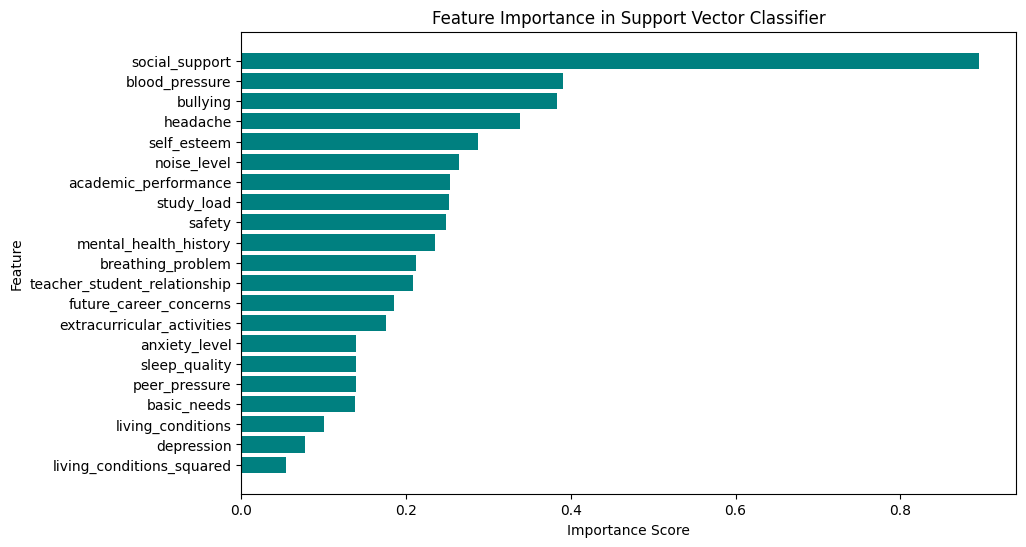

In [332]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.mean(np.abs(models[0].coef_), axis=0)

# Create a DataFrame for feature importance
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='teal')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title("Feature Importance in Support Vector Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

{'0': {'precision': 0.9358288770053476, 'recall': 0.938337801608579, 'f1-score': 0.9370816599732262, 'support': 373.0}, '1': {'precision': 0.925207756232687, 'recall': 0.925207756232687, 'f1-score': 0.925207756232687, 'support': 361.0}, '2': {'precision': 0.9508196721311475, 'recall': 0.9482288828337875, 'f1-score': 0.9495225102319236, 'support': 367.0}, 'accuracy': 0.9373297002724795, 'macro avg': {'precision': 0.9372854351230607, 'recall': 0.9372581468916845, 'f1-score': 0.9372706421459457, 'support': 1101.0}, 'weighted avg': {'precision': 0.937343315890214, 'recall': 0.9373297002724795, 'f1-score': 0.9373353500682374, 'support': 1101.0}}


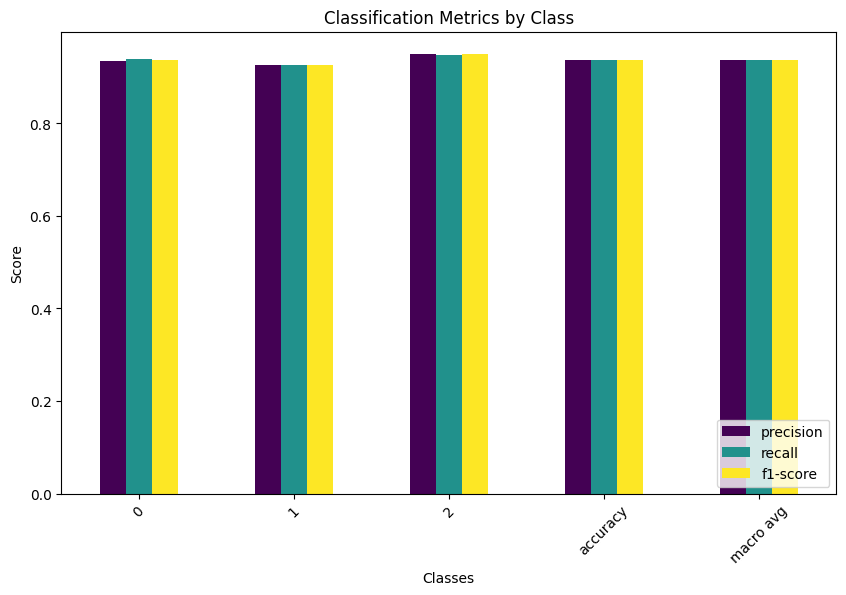

In [333]:
from sklearn.metrics import classification_report

# Generate classification report as a DataFrame
report = classification_report(Y_test_combined,combined_predictions,target_names=class_labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report)
# Plot precision, recall, and F1-score
report_df.iloc[:-1, :-1].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Classification Metrics by Class")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

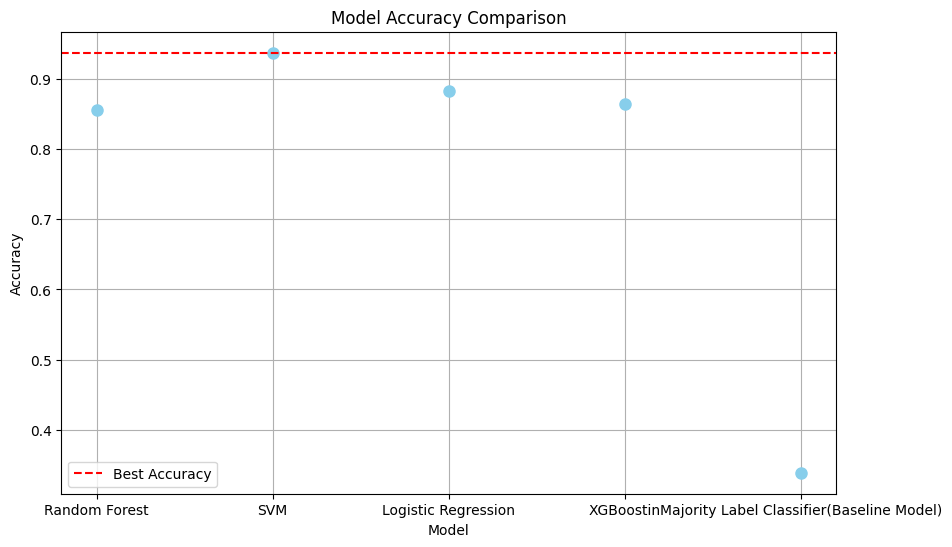

In [334]:
import matplotlib.pyplot as plt
model_names = ['Random Forest', 'SVM', 'Logistic Regression', 'XGBoostin', 'Majority Label Classifier(Baseline Model)']
accuracies = [rf_accuracy, svm_accuracy, logistic_regression_accuracy, XGB_accuracy, training_accuracy]  # Replace with actual values

plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, 'o', color='skyblue', markersize=8)  # 'o' creates dots
plt.axhline(y=max(accuracies), color='red', linestyle='--', label="Best Accuracy")  # Optional: Line to indicate max accuracy
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.legend()
plt.show()

## Model Accuracy Comparison Results

The figure above shows the accuracy of multiple machine learning models for the given classification problem.

- **Random Forest**, **SVM**, **Logistic Regression**, and **XGBoost** models demonstrate competitive performance, with accuracies ranging from approximately **85% to 94%**.
- The **Support Vector Machine (SVM)** achieved the **best accuracy** among all the models, as highlighted by the red dashed line near **94%**.
- In contrast, the **Majority Label Classifier (Baseline Model)** shows significantly lower accuracy (around **40%**), indicating the superiority of the trained machine learning models over the baseline.

### Key Observations:
1. The **SVM model** outperformed others, achieving the highest accuracy.
2. **Random Forest** and **XGBoost** delivered slightly lower accuracies but remain close contenders.
3. The baseline model's poor accuracy highlights the need for robust machine learning methods in this problem domain.

---

This summary can be included as part of your final report or notebook to interpret the results visually and contextually.


## Results and Analysis

The figure above provides a visual comparison of the accuracies achieved by various machine learning models for the given classification task. The analysis highlights the strengths and weaknesses of each model and underscores the importance of selecting robust methods for optimal performance.

### Accuracy Comparison:
1. **Support Vector Machine (SVM):**
   - The **SVM model** achieved the **highest accuracy** of approximately **94%**, as emphasized by the red dashed line in the graph.
   - This result demonstrates the effectiveness of the linear kernel and the chosen hyperparameters (C=0.2 and decision_function_shape='ovr') in correctly classifying the data.

2. **Random Forest, Logistic Regression, and XGBoost:**
   - These models performed competitively, with accuracies ranging between **85% and 89%**.
   - While slightly lower than the SVM, their performance remains strong and demonstrates their reliability for this classification problem.

3. **Baseline Model (Majority Label Classifier):**
   - The **Majority Label Classifier**, used as a baseline, yielded a significantly lower accuracy of approximately **34%**.
   - This stark contrast underscores the importance of applying advanced machine learning techniques, as simple majority-based predictions fail to capture the underlying patterns in the data.

### Key Observations:
- The **Support Vector Machine (SVM)** emerged as the **best-performing model**, showcasing its ability to effectively separate classes using a linear decision boundary.
- Both **Random Forest** and **XGBoost** models, despite performing slightly below the SVM, remain strong alternatives with competitive results. These models could be further optimized with hyperparameter tuning to potentially close the accuracy gap.
- The **Logistic Regression** model delivered accuracy comparable to Random Forest and XGBoost, suggesting that the relationships between the features and the target are well-suited to linear models.
- The **Baseline Model**'s poor accuracy (34%) demonstrates its inability to address the complexity of the dataset and highlights the necessity of more advanced classification techniques.

### Conclusion:
The results clearly show that the **SVM model** provides the highest accuracy, making it the most suitable choice for this classification task. However, other models like **Random Forest** and **XGBoost** also show promise and can serve as robust alternatives. The sharp difference between the baseline model and the machine learning models further emphasizes the effectiveness of using trained classifiers over simplistic methods.

This analysis highlights the importance of model selection and hyperparameter tuning in achieving optimal performance for classification problems.
